In [1]:
import os
import sys
# from parent directory imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import copy
import pickle
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

gpu = "cuda"

In [2]:
global_seed = 42

In [3]:
os.makedirs("results_regression_sine", exist_ok=True)

### Sine Dataset

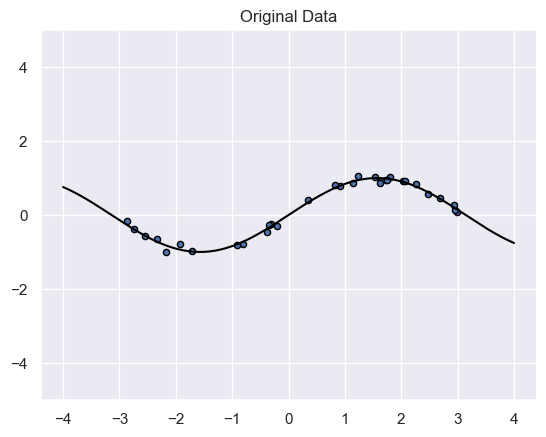

In [4]:
n_samples = 32
limits = 5
test_bound = 6

rng = np.random.default_rng(seed=global_seed)

x_train = np.sort(rng.random((n_samples, 1)) * (2 * np.pi) - np.pi)
y_train = np.sin(x_train[:, 0]) + rng.normal(0, 0.1, (n_samples, ))
x_test = np.linspace(-test_bound, test_bound, 5 * n_samples).reshape(-1, 1)
y_test = np.sin(x_test[:, 0]) + rng.normal(0, 0.1, (5 * n_samples, ))

plt.title("Original Data")
plt.scatter(x_train, y_train, s=20, edgecolors="black")
plt.plot(np.linspace(-4, 4, 256), np.sin(np.linspace(-4, 4, 256)), c="black")
plt.ylim(-limits, limits)
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.optim import Optimizer

import hamiltorch
from laplace import Laplace
from torch_sgld.sgld import SGLD
from torch_sgld.lr_scheduler import CosineLR, ABAnnealingLR

from source.utils.seeding import fix_seeds

device = gpu if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Helper Functions

Helper functions for network training and visualizations

In [6]:
def fit(network, opt, x_train, y_train, iterations, batch_size, plot=True):
    losses = list()
    mse = nn.MSELoss()

    for _ in tqdm(range(iterations), desc="training"):
        idx = torch.randperm(x_train.size(0))[:batch_size]
        pred = network.forward(x_train[idx])

        loss = mse(pred, y_train[idx])

        losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

    if plot:
        plt.plot(losses)
        plt.ylabel("Training Loss")
        plt.xlabel("Iterations")
        plt.yscale("log")
        plt.show()

    return network


def visualize(pred_test, x_train, y_train, x_test, title, filename, plotlines=False, std=None):
    try:
        x_train = x_train.cpu().numpy()
    except:
        pass
    try:
        y_train = y_train.cpu().numpy()
    except:
        pass
    try:
        x_test = x_test.cpu().numpy()
    except:
        pass
    try:
        pred_test = pred_test.cpu().numpy()
    except:
        pass

    plt.figure(figsize=(6, 4.5))
    #plt.title(title, fontsize=20)
    plt.scatter(x_train, y_train, s=20, c="C0", edgecolors="black", zorder=99)
    if not plotlines:
        if std is None:
            plt.plot(x_test, np.nanmean(pred_test, axis=0), color="C1")
            factors = [1, 2, 3]
            for factor in factors:
                cis = (np.nanmean(pred_test, axis=0) - factor * np.nanstd(pred_test, axis=0),
                    np.nanmean(pred_test, axis=0) + factor * np.nanstd(pred_test, axis=0))
                plt.gca().fill_between(x_test[:, 0], cis[0][:, 0], cis[1][:, 0], alpha=0.8 / len(factors), color="C1")
        else:
            cis = (np.nanmean(pred_test, axis=0) - std,
                    np.nanmean(pred_test, axis=0) + std)
            plt.gca().fill_between(x_test[:, 0], cis[0][:, 0], cis[1][:, 0], alpha=0.3, color="C0")
    else:
        for i in range(len(pred_test)):
            plt.plot(x_test, pred_test[i])
    plt.xlim(-test_bound, test_bound)
    plt.ylim(-limits, limits)
    plt.tight_layout()
    plt.savefig(os.path.join("results_regression_sine", filename))
    plt.show()

## General Hyperparameters

In [80]:
# parameters
lr = 1e-3
iterations = 1_000
batch_size = 16
hidden_size = 200
weight_decay = 1e-3

## HMC

In [152]:
# parameters
step_size = 0.0005
num_samples = 1000
burn = 100
L = 20
tau_out = 10.
mass = 1e0

hmc_device = "cpu" # faster on cpu for our setup

In [153]:
fix_seeds(global_seed)

network = nn.Sequential(nn.Linear(1, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1))

network.to(hmc_device)
network.train()

params_init = hamiltorch.util.flatten(network).to(hmc_device).clone()
print('Parameter size: ',params_init.shape[0])

Parameter size:  81001


In [154]:
tau_list = []
tau = 1.
for w in network.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [155]:
x_train = torch.as_tensor(x_train).to(device=hmc_device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=hmc_device, dtype=torch.float32).reshape(-1, 1)
x_test = torch.as_tensor(x_test).to(device=hmc_device, dtype=torch.float32).reshape(-1, 1)
y_test = torch.as_tensor(y_test).to(device=hmc_device, dtype=torch.float32).reshape(-1, 1)

inv_mass = torch.ones(params_init.shape, device=hmc_device) / mass
integrator = hamiltorch.Integrator.IMPLICIT
sampler = hamiltorch.Sampler.HMC

params_hmc = hamiltorch.sample_model(network, x_train, y_train, model_loss='regression', integrator=integrator, sampler=sampler, params_init=params_init, 
                                     num_samples=num_samples, burn=burn, step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, inv_mass=inv_mass)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:02:00 | 0d:00:00:00 | #################### | 1000/1000 | 8.31        
Acceptance Rate 0.94


In [156]:
pred_list, log_prob_list = hamiltorch.predict_model(network, x=x_test, y=y_test, model_loss='regression', samples=params_hmc[:], tau_out=tau_out, tau_list=tau_list)

print(tau_list[0])
print(tau_out)
print('\nExpected validation log probability: {:.2f}'.format(torch.stack(log_prob_list).mean()))
print('\nExpected MSE: {:.2f}'.format(((pred_list.mean(0) - y_test)**2).mean()))

tensor(1.)
10.0

Expected validation log probability: -78952.05

Expected MSE: 0.21


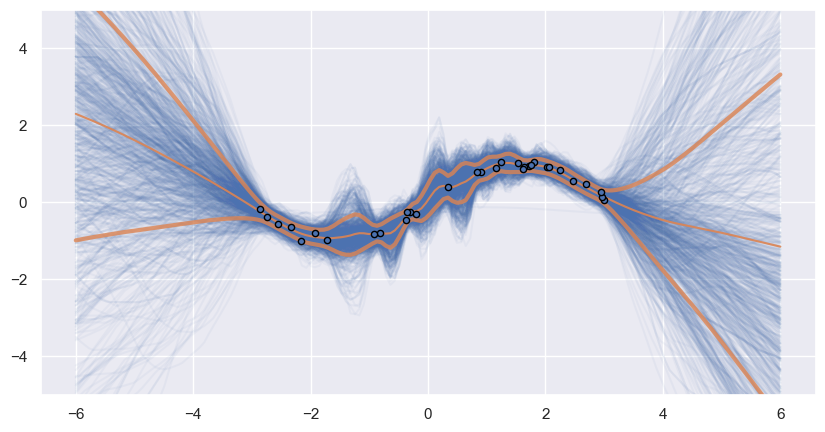

In [157]:
plt.figure(figsize=(10,5))
plt.plot(x_test.cpu().numpy(),pred_list.cpu().numpy().squeeze().T, 'C0',alpha=0.051)
plt.plot(x_test.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T, 'C1',alpha=0.9)
plt.plot(x_test.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T + pred_list.std(0).cpu().numpy().squeeze().T, 'C1',alpha=0.8,linewidth=3)
plt.plot(x_test.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T - pred_list.std(0).cpu().numpy().squeeze().T, 'C1',alpha=0.8,linewidth=3)

plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), s=20, edgecolors="black", zorder=99)
plt.ylim([-5,5])
plt.show()

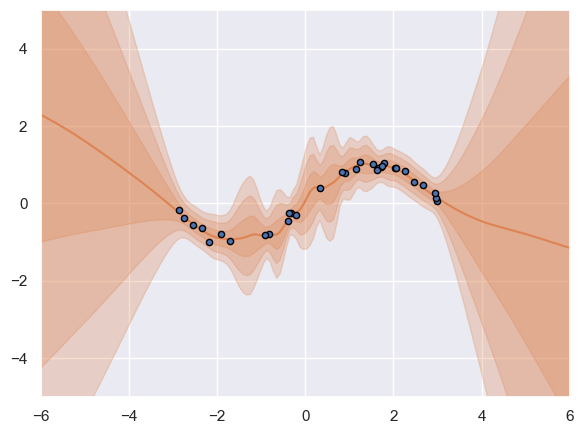

In [158]:
visualize(pred_list, x_train, y_train, x_test, "Hamilton Monte Carlo (Epistemic)", "reg_hmc_epi.pdf")

## SG-MCMC

In [15]:
T = int(1e4)
momentum = 0.9 # = 0 for SGLD, != 0 for SGHMC
sgld_lr = 5e-2
temperature = 0.01

beta = 0.8
n_cycles = 5 # set to zero to use ABScheduler

final_lr = 1e-4
gamma = 0.55
burn = 0

In [16]:
fix_seeds(global_seed)

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.float32).reshape(-1, 1)
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32).reshape(-1, 1)

network = nn.Sequential(nn.Linear(1, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1))

network.to(device)
network.train()

sgmcmc = SGLD(network.parameters(), lr=sgld_lr, momentum=momentum, weight_decay=weight_decay, temperature=temperature)
if n_cycles == 0:
    sgmcmc_scheduler = ABAnnealingLR(sgmcmc, final_lr=final_lr, T_max=T, gamma=gamma)
else:
    sgmcmc_scheduler = CosineLR(sgmcmc, n_cycles=n_cycles, n_samples=T, T_max=T, beta=beta)

samples = []
mse = nn.MSELoss()
for t in tqdm(range(T)):
    sgmcmc.zero_grad()

    idx = torch.randperm(x_train.size(0))[:batch_size]
    pred = network.forward(x_train[idx])

    loss = mse(pred, y_train[idx])

    loss.backward()

    if n_cycles != 0 and sgmcmc_scheduler.get_last_beta() <= sgmcmc_scheduler.beta:
        sgmcmc.step(noise=False)
    else:
        sgmcmc.step()

        if n_cycles != 0 or t >= burn:
            with torch.no_grad():
                samples.append(network(x_test).detach())

    sgmcmc_scheduler.step()

samples = torch.stack(samples).squeeze(1)

100%|██████████| 10000/10000 [00:24<00:00, 403.69it/s]


In [17]:
yy = y_train.cpu().numpy()
x = x_train.cpu().numpy()
x_test = x_test.cpu().numpy()
samples = samples.cpu().numpy()
print(samples.shape)

(1995, 160, 1)


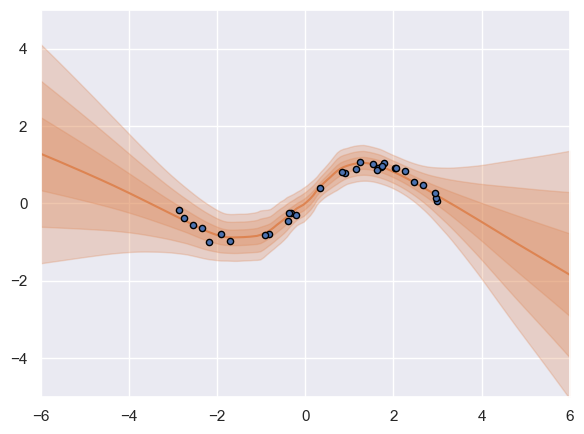

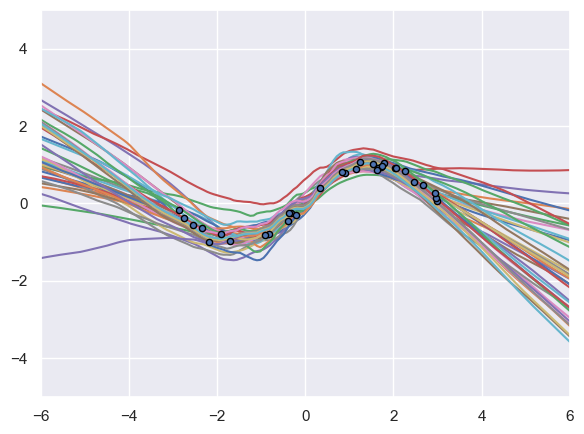

In [18]:
visualize(samples, x_train, y_train, x_test, "SG-MCMC (Epistemic)", "reg_sgmcmc_epi.pdf")
visualize(samples[::10], x_train, y_train, x_test, "SG-MCMC", "reg_sgmcmc_lines.pdf", plotlines=True)

## Laplace

In [19]:
# parameters
subset_of_weights = "last_layer" # all, last_layer, subnetwork
hessian_structure = "kron" # full, kron, diag, lowrank

h_epochs = 10_000
n_samples = 5_000

training: 100%|██████████| 1000/1000 [00:03<00:00, 298.45it/s]


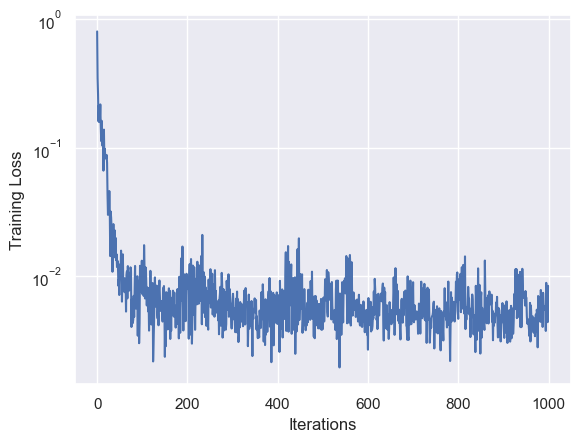

In [20]:
fix_seeds(global_seed)

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.float32).reshape(-1, 1)
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32).reshape(-1, 1)

network = nn.Sequential(nn.Linear(1, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1))

network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

network = fit(network, opt, x_train, y_train, iterations, batch_size, plot=True)

In [21]:
la = Laplace(network, 'regression',
             subset_of_weights=subset_of_weights,
             hessian_structure=hessian_structure,
             )

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), 
        batch_size=batch_size
    )
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = optim.Adam([log_prior, log_sigma], lr=lr)
for i in tqdm(range(h_epochs)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

100%|██████████| 10000/10000 [00:33<00:00, 295.51it/s]


In [22]:
pred_test = la.predictive_samples(x_test, pred_type='glm', n_samples=n_samples).cpu().numpy()
print(pred_test.shape)

(5000, 160, 1)


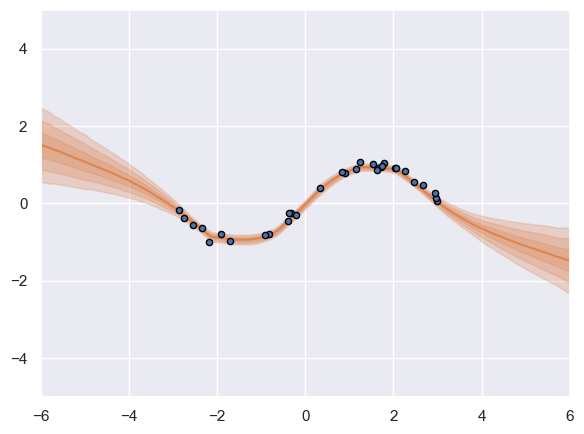

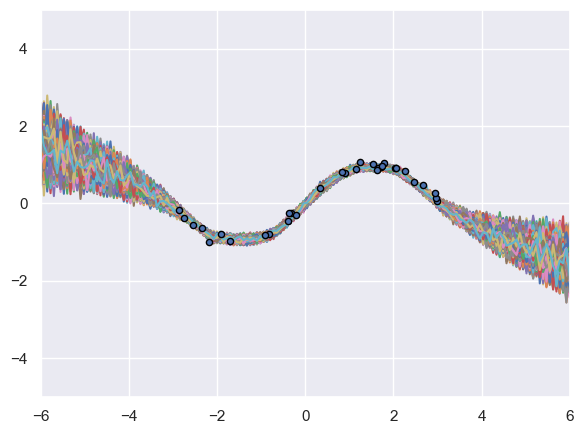

In [23]:
visualize(pred_test, x_train, y_train, x_test, "Laplace (Epistemic)", "reg_laplace_epi.pdf")
visualize(pred_test, x_train, y_train, x_test, "Laplace", "reg_laplace_lines.pdf", plotlines=True)

## Ensemble Methods

In [24]:
n_ensemble = 10

training: 100%|██████████| 1000/1000 [00:03<00:00, 298.18it/s]


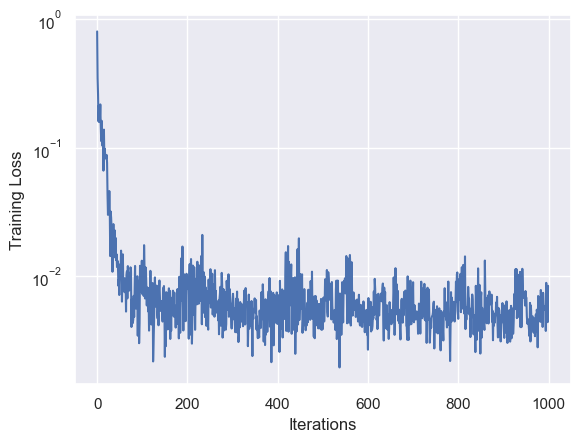

training: 100%|██████████| 1000/1000 [00:03<00:00, 260.83it/s]


In [25]:
fix_seeds(global_seed)

pred_test, std_test = list(), list()

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.float32).reshape(-1, 1)
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32).reshape(-1, 1)

mse = nn.MSELoss()

for e in range(n_ensemble):
    network = nn.Sequential(nn.Linear(1, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, 1))
    network.to(device)
    network.train()

    opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

    network = fit(network, opt, x_train, y_train, iterations, batch_size, plot=(e == 0))

    with torch.no_grad():
        network.eval()
        preds = network.forward(x_test).detach().cpu().numpy()
        pred_test.append(preds)
        std_test.append(mse(network.forward(x_train), y_train).cpu().item())
pred_test = np.asarray(pred_test)

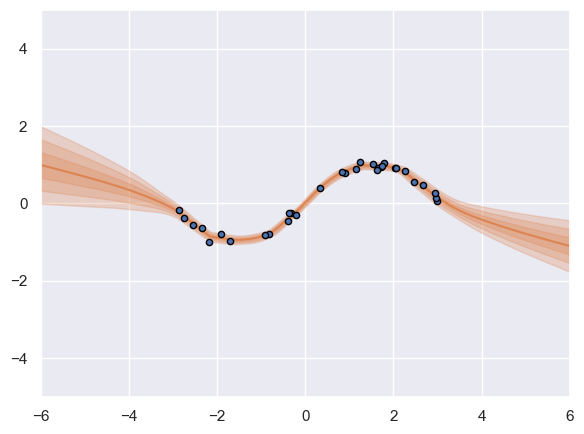

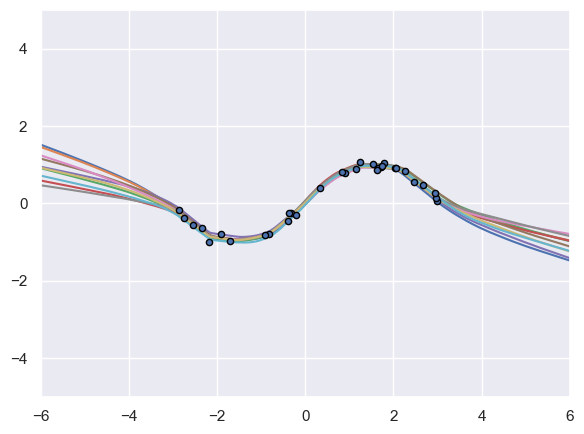

In [26]:
visualize(pred_test, x_train, y_train, x_test, "Ensemble (Epistemic)", "reg_ensemble_epi.pdf")
visualize(pred_test, x_train, y_train, x_test, "Ensemble", "reg_ensemble_lines.pdf", plotlines=True)

## MC-Dropout

In [27]:
# parameters
dropout_rate = 0.1
forward_passes = 1_000

training: 100%|██████████| 1000/1000 [00:03<00:00, 258.82it/s]


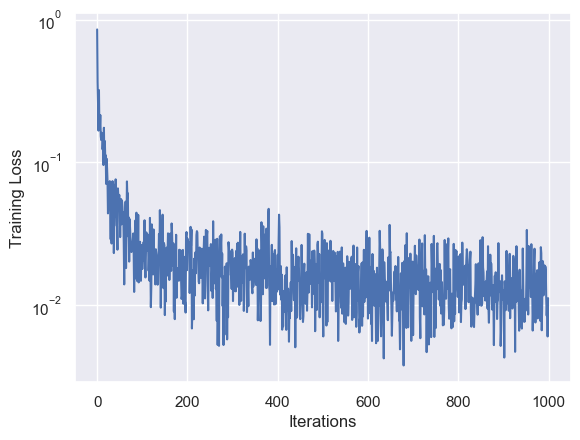

inference: 100%|██████████| 1000/1000 [00:01<00:00, 623.47it/s]


In [28]:
fix_seeds(global_seed)

pred_test, std_test = list(), list()

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.float32).reshape(-1, 1)
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32).reshape(-1, 1)

mse = nn.MSELoss()
network = nn.Sequential(nn.Linear(1, hidden_size),
                        nn.Dropout(p=dropout_rate),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.Dropout(p=dropout_rate),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.Dropout(p=dropout_rate),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1))
network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

network = fit(network, opt, x_train, y_train, iterations, batch_size, plot=True)

# Sample predictions for test samples
with torch.no_grad():
    network.train()
    for _ in tqdm(range(forward_passes), desc="inference"):
        preds = network.forward(x_test).detach().cpu().numpy()
        pred_test.append(preds)
        std_test.append(mse(network.forward(x_train), y_train).cpu().item())
pred_test = np.asarray(pred_test)

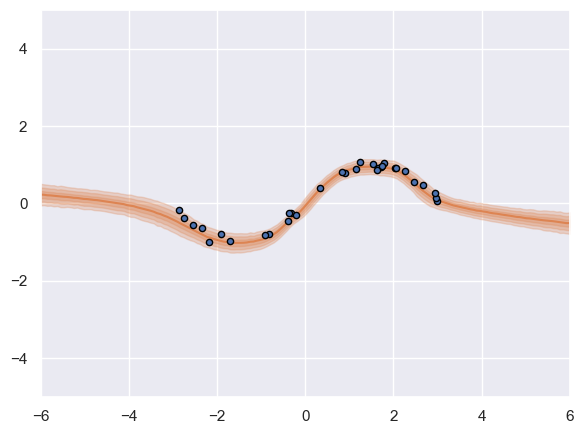

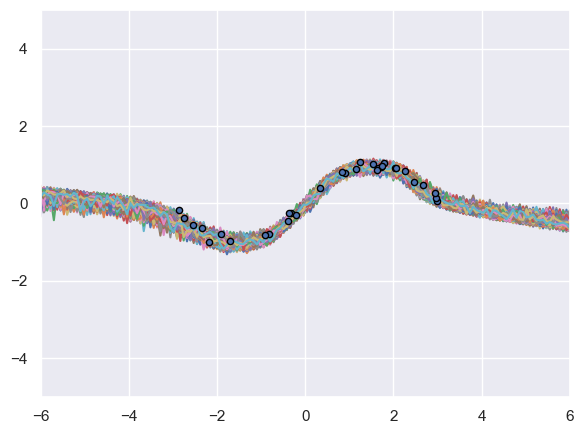

In [29]:
visualize(pred_test, x_train, y_train, x_test, "MC-Dropout (Epistemic)", "reg_mc_dropout_epi.pdf")
visualize(pred_test, x_train, y_train, x_test, "MC-Dropout", "reg_mc_dropout_lines.pdf", plotlines=True)

## QUAM

In [75]:
# parameters
n_adversaries = 1
optim_steps = 50
adv_iterations = 6
lr_adv = 1e-4
offset = 1e-2
gamma = 1e-3
c_0 = 5e-1
eta = 4

verbose=False

training: 100%|██████████| 1000/1000 [00:04<00:00, 243.81it/s]


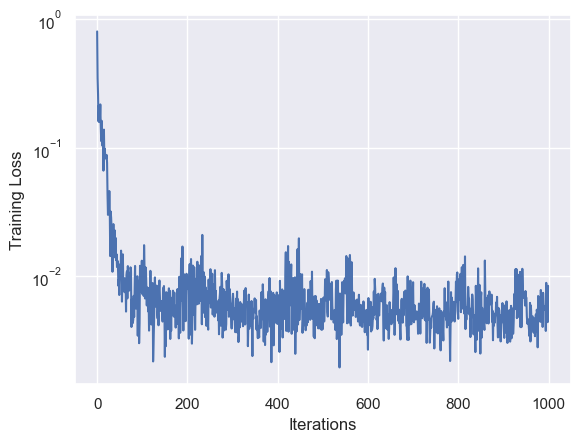

inference: 100%|██████████| 160/160 [03:33<00:00,  1.33s/it]


In [76]:
fix_seeds(global_seed)

pred_test = list()

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.float32).reshape(-1, 1)
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32).reshape(-1, 1)

mse = nn.MSELoss()

network = nn.Sequential(nn.Linear(1, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1))
network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

network = fit(network, opt, x_train, y_train, iterations, batch_size, plot=True)

with torch.no_grad():
    network.eval()
    train_pred = network.forward(x_train)
    train_mse = mse(train_pred, y_train)
    network.train()

# Fit adversaries
for a in [-1, 1] * n_adversaries:
    preds = list()

    for i in tqdm(range(len(x_test)), desc="inference"):
        adversarial_network = copy.deepcopy(network)
        best_network = copy.deepcopy(network)
        min_objective_loss, best_iter = 1e8, 0

        with torch.no_grad():
            adversarial_network[-1].bias.add_(torch.ones_like(adversarial_network[-1].bias).to(device) * offset * a)

        opt = optim.Adam(params=adversarial_network.parameters(), lr=lr_adv, weight_decay=weight_decay)
        losses = []

        with torch.no_grad():
            test_pred = network.forward(x_test[i].reshape(1, -1))

        c = c_0
        for ad_i in range(adv_iterations):
            for op_s in range(optim_steps):

                # maximize L1 loss on new datapoint
                output = adversarial_network.forward(x_test[i].reshape(1, 1))
                objective = a * (test_pred - output)

                # minimize MSE on training data
                penalty = mse(adversarial_network(x_train), y_train)

                loss = objective + c * (penalty - train_mse - gamma)

                opt.zero_grad()
                loss.backward()
                opt.step()

                losses.append((objective.item(), penalty.item()))
                
                criteria = np.asarray(losses[-1:])
                if criteria[-1, 0] < min_objective_loss and np.mean(criteria[:, 1]) <= train_mse.item() + gamma and criteria[-1, 1] <= train_mse.item() + gamma:
                    min_objective_loss = criteria[-1, 0]
                    best_iter = ad_i * optim_steps + op_s
                    best_network = copy.deepcopy(adversarial_network)

            c *= eta
            
        losses = np.asarray(losses)
        if verbose and a < 2 and i%10 == 0:#(i == 0 or i == int(len(x_test) // 6) or i == int(len(x_test) // 6) * 2 or i == int(len(x_test) // 6) * 3):
            plt.title(f"{i+1}/{len(x_test)}")
            plt.plot(-np.minimum(losses[:, 0], 0), label="adv loss")
            plt.plot(losses[:, 1], label="penalty loss")
            plt.plot([gamma if x==0 else float("nan") for x in losses[:, 1]], linestyle="dotted", color="C1")
            plt.hlines(y=1e1, xmin=0, xmax=(optim_steps * adv_iterations) - 1, colors="black")
            plt.hlines(y=train_mse.cpu().item(), xmin=0, xmax=(optim_steps * adv_iterations) - 1, colors="black", linestyle="dashed")
            plt.hlines(y=train_mse.cpu().item() + gamma, xmin=0, xmax=(optim_steps * adv_iterations) - 1, colors="black", linestyle="dotted")
            plt.vlines(x=best_iter, ymin=np.min(losses), ymax=1e1, colors="black", linestyles="dashed")
            plt.yscale("log")
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend()
            plt.show()

        with torch.no_grad():
            best_network.eval()
            test_pred = best_network.forward(x_test[i].reshape(1, -1))
            preds.append(test_pred.cpu().item())
            best_network.train()

    pred_test.append(preds)


pred_test = np.asarray(pred_test).reshape(2 * n_adversaries, -1, 1)

# Sample predictions for test samples
with torch.no_grad():
    network.eval()
    preds = network.forward(x_test).detach().cpu().numpy()
    std_test = mse(network.forward(x_train), y_train).cpu().item()

In [77]:
with open(os.path.join("results_regression_sine", "preds.pkl"),"wb") as f:
    pickle.dump(pred_test, f)

In [78]:
with open(os.path.join("results_regression_sine", "preds.pkl"),"rb") as f:
    pred_test = pickle.load(f)

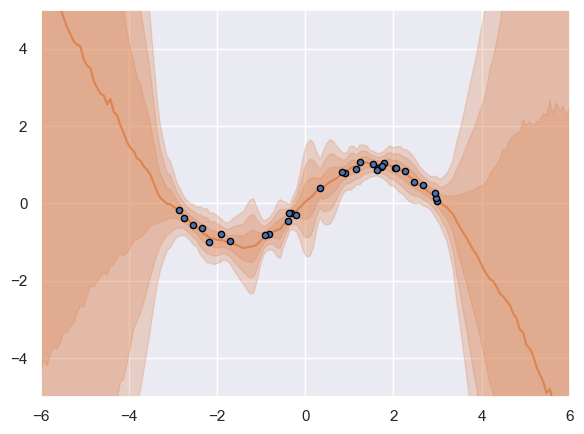

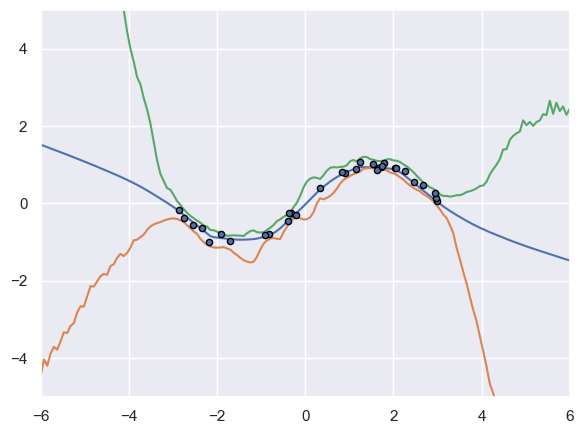

In [79]:
visualize(pred_test, x_train, y_train, x_test, "QUAM (Epistemic)", "reg_quam_epi.pdf")
visualize(np.concatenate((preds.reshape(1, -1, 1), pred_test), axis=0), x_train, y_train, x_test, "QUAM", "reg_quam_lines.pdf", plotlines=True)